教師なし学習を用いたデータ変換にはさまざまな動機がある。もっとも一般的な動機としては可視化、データの圧縮、以降の処理に適した表現の発見があげられる。  
よく用いられるのがPCA(principal component analysis)であり、他にも主に特徴量抽出に用いられるNMF(non negative matirx factorization: NMF)と2次元散布図を用いたデータの可視化に用いられるt-SNEである

In [14]:
import mglearn
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

%matplotlib inline

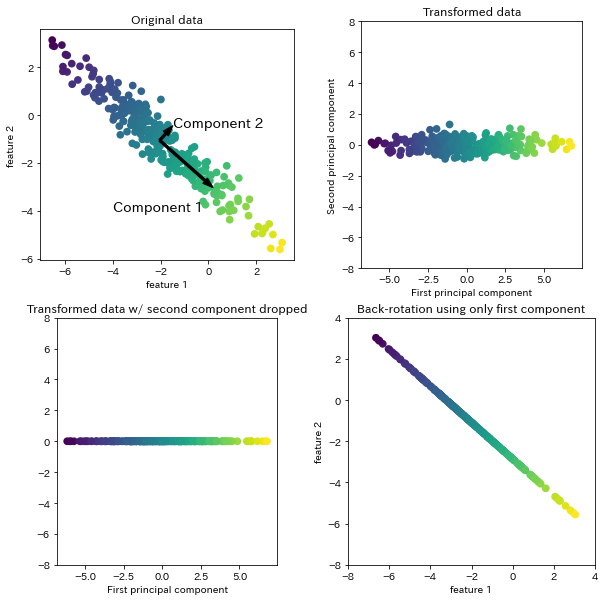

In [2]:
mglearn.plots.plot_pca_illustration()

最初のプロット(左上)は元のデータセットを示している。  
PCAは、まずもっとも分散が大きい方向をみつけてそれを「第1成分」というラベルをつける。データはこの方向(もしくはベクトル)に対してもっとも情報をもつ。つまりこの方向は特徴量がもっとも相互に関係する方向である。次に第1成分と直行する方向の中から、もっとも情報を持っている方向を探す。2次元だと直行する方向は1つしか存在しないが、高次元ならいくつでもありえる。このようにして見つけて行く「方向」を**主成分**と呼ぶ。  

2つめ(右上)にプロットは同じデータを、第1成分がx軸に沿い、第2成分がｙ軸に沿うように回転させたものである。原点の周辺にデータがくるように、回転させる前にデータから平均値を引いてある。**PCAで見つかった回転後の表現では2つの軸の相関はない。つまり、この表現でのデータの相関行列は対角成分を除いてゼロである。**  

**主成分のうちいくつかだけを残すことで、PCAを次元削減に使うことができる。**この例では3つめのプロット(左下)も示すように1つ目の主成分だけを残す。このようにすると2次元のデータセットが1次元になる。ただし元の特徴量のうち一つを残しているわけではなく、最も興味深い方向(1つ目のプロットの左上から右下向き)、すなわち第1成分をみつけ、その方向を維持している。

**逆回転して平均を足し、データを元に戻すこともできる。こうして得られたのが4つ目(右下)のプロットである。データポイントは元の特徴量空間にあるが、第1成分に含まれている情報しか維持されていない。このような変換はデータからノイズを取り除いたり、主成分で維持された情報を可視化するために用いられることがある。**

## cancerデータセットのPCAによる可視化

PCAの最も一般的なアプリケーションは高次元のデータの可視化である。2つ以上の特徴量を持つデータの散布図をつくことは難しい。

cancerデータは特徴量が30なので単純にtarget=0, 1に対して30個のヒストグラムを書くことで可視化はできる

In [13]:
cancer.data.shape

(569, 30)

In [4]:
cancer = load_breast_cancer()

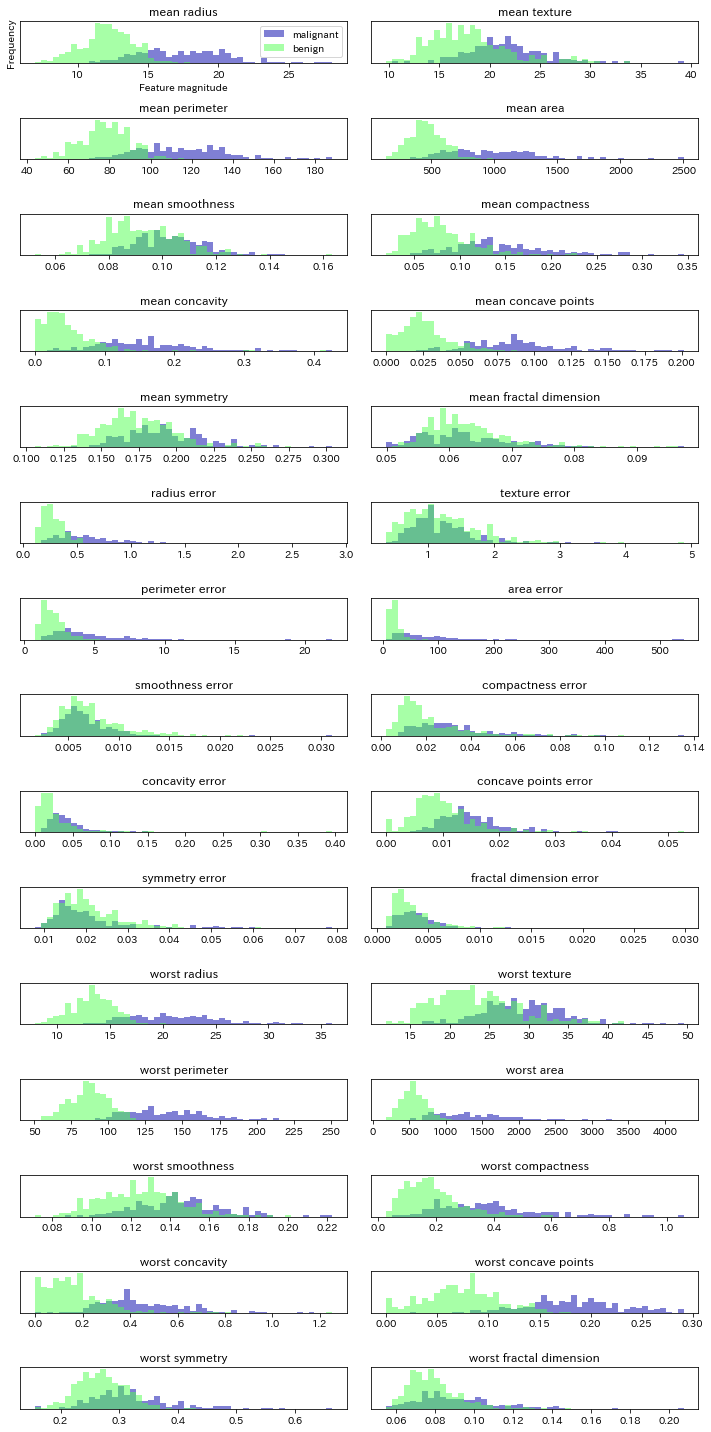

In [12]:
fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target==0]
benign = cancer.data[cancer.target==1]

ax = axes.ravel()

for i in range(30):
    _,  bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
    
ax[0].set_xlabel('Feature magnitude')
ax[0].set_ylabel('Frequency')
ax[0].legend(['malignant', 'benign'], loc='best')
fig.tight_layout()

こうしてみると特徴量に対する2つのクラスの分布がわかり、どの特徴量が要請と悪性を見分けるに役立ちそうか類推することができる。  
例えば「smoothness error」のヒストグラムはほとんど重ねっているのであまり情報がなさそうだ。一方、「worst concave points」のヒストグラムはほとんど重ねっていないので情報が多い。  

しかしこのプロットをみても個々の特徴量の相関や、それがクラス分類に与える影響については何もわからない。PCAを用いると、主な相関を捉えることができるのでもう少し全体像がみやすくなる。最初の2つの主成分を用いて、2次元空間上の一つの散布図としてみてみよう。

PCAを適用する前に、データをStandardScalerでスケーリングして、個々の特徴量の分散が1になるようにする。  

sklearnのPCAはデフォルトではデータの回転(と平均値のシフト)しか行わなわず、すべての主成分を維持する。データの次元削減を行うにはPCAオブジェクトを作る際に、維持する主成分の数を指定する

In [15]:
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

In [16]:
from sklearn.decomposition import PCA
#最初の2つの主成分だけを維持する
pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
X_pca = pca.transform(X_scaled)
print('Original shape: {}'.format(str(X_scaled.shape)))
print('Reduce shape: {}'.format(str(X_pca.shape)))

Original shape: (569, 30)
Reduce shape: (569, 2)


Text(0, 0.5, 'Second principal component')

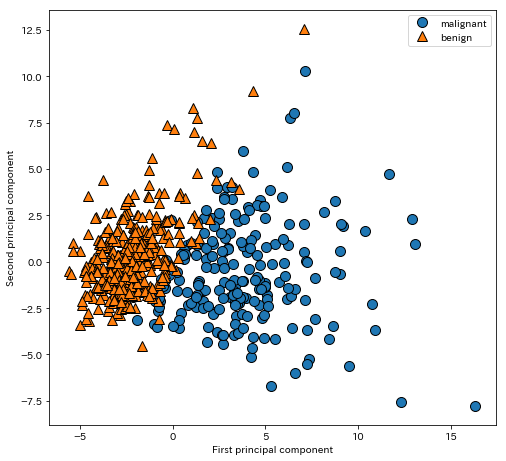

In [18]:
plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc='best')
plt.gca().set_aspect('equal')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

PCAは教師なし学習なので、適切な回転を見つけるのに教師データは全く使用していない。データの相関をみているだけだ。PCAによって30から2次元のデータを削減した結果、この2次元空間で2つのクラスが綺麗に分離できていることがわかるだろう。これを見れば(この空間での直線を学習する)線形モデルの分類器でもそれなりに分類できそうだ。また悪性のデータポイントは良性のデータポイントよりも広がっていることがわかる。これは先ほどのヒストグラムからも確かめられる。

**PCAの欠点はプロットした2つの軸の解釈が容易ではないことが多い(それが一体なにを表しているか分からない)。**2つの主成分の方向はもとのデータの方向に対応しており、元の特徴量の組み合わせにすぎない。この組み合わせは一般に複雑なのだ。主成分はPCAを行う過程で、components_に格納される

In [20]:
print('PCA component shape: {}'.format(pca.components_.shape))

PCA component shape: (2, 30)


components_のそれぞれの行がひとつの主成分に対応する。行は重要度によってソートされ、第1成分が最初に来る。列はPCA変換する前のもとの特徴量に対応する。

In [21]:
print('PCA components:\n{}'.format(pca.components_))

PCA components:
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


Text(0, 0.5, 'Principal components')

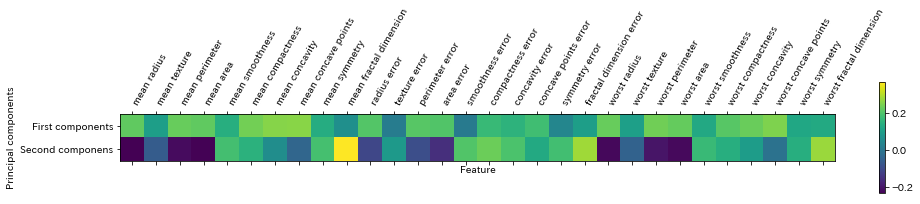

In [22]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ['First components', 'Second componens'])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)), cancer.feature_names, rotation=60, ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal components')

係数をヒートマップで表した。  
**すべての特徴量が同じ符号になっていることがわかる。これはすべての特徴量に一般的な相関があるということを意味する。**ある特徴量が大きければ、他の特徴量が大きくなる傾向にある。第2成分の符号は入り混じっている。また両方とも30の特徴量すべてが入り混ざっている。このため散布図の軸を説明するのは非常に難しい。

## 固有顔による特徴量抽出
PCAの利用方法の一つには特徴量抽出であった。**特徴量抽出の背後には、データには与えられたもとの表現よりも解析に適した表現があり、それを見つけることが可能であるという考え方がある。**  

PCAを用いた画像からの特徴量抽出の例をみてみよう

In [25]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20 ,resize=0.7)
image_shape = people.images[0].shape

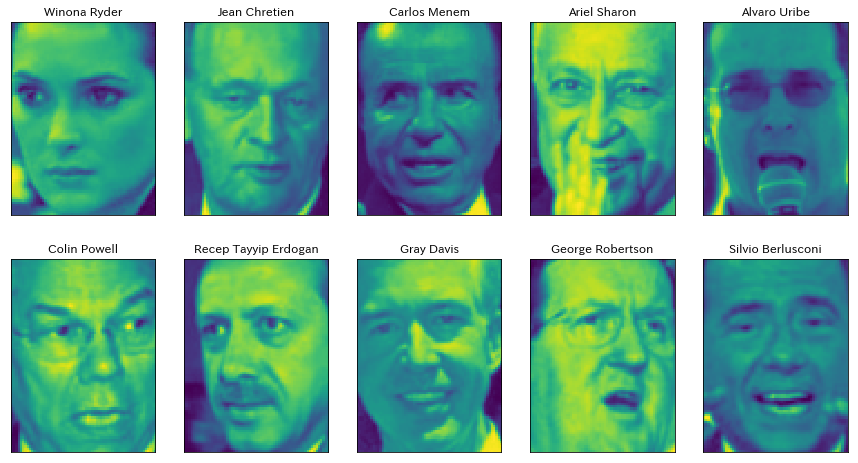

In [27]:
fig, axes = plt.subplots(2,5, figsize=(15, 8), subplot_kw={'xticks':(), 'yticks':()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [29]:
print('people.image.shape {}'.format(people.images.shape))
print('Number of class {}'.format(len(people.target_names)))

people.image.shape (3023, 87, 65)
Number of class 62


In [30]:
people.target

array([61, 25,  9, ..., 14, 15, 14])

In [31]:
np.bincount(people.target)

array([ 39,  35,  21,  36,  20,  77,  42,  24,  29,  21, 236,  31, 121,
        22, 530, 109,  44,  26,  30,  22,  39,  71,  20,  28,  52,  55,
        21,  42,  21,  24,  20,  53,  31,  23,  28,  60,  32,  41,  22,
        41,  48,  29,  33,  20,  22,  37,  20,  22,  30,  27,  32,  26,
        23,  52,  33,  23,  25,  33, 144,  32,  49,  24])

In [32]:
counts = np.bincount(people.target)

for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='    ')
    if (i+3) % 3 == 0:
        print()

Alejandro Toledo           39    
Alvaro Uribe               35    Amelie Mauresmo            21    Andre Agassi               36    
Angelina Jolie             20    Ariel Sharon               77    Arnold Schwarzenegger      42    
Atal Bihari Vajpayee       24    Bill Clinton               29    Carlos Menem               21    
Colin Powell              236    David Beckham              31    Donald Rumsfeld           121    
George Robertson           22    George W Bush             530    Gerhard Schroeder         109    
Gloria Macapagal Arroyo    44    Gray Davis                 26    Guillermo Coria            30    
Hamid Karzai               22    Hans Blix                  39    Hugo Chavez                71    
Igor Ivanov                20    Jack Straw                 28    Jacques Chirac             52    
Jean Chretien              55    Jennifer Aniston           21    Jennifer Capriati          42    
Jennifer Lopez             21    Jeremy Greenstock          24    

各画像の偏りを減らすために、各人の画像を50に制限する  
こうしなと特徴量抽出がGeorge W Bush に偏る

In [33]:
mask = np.zeros(people.target.shape, dtype=np.bool)

for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

In [34]:
X_people = people.data[mask]
y_people = people.target[mask]

In [35]:
#0-255で表現されるグレースケールに変換
X_people = X_people / 255.

一般的な画像認識タスクとして、見たことない顔がDBの中の人物と一致するかどうかを判定するタスクがある。  
この問題を解く一つの方法は、個々の異なる人物を異なるクラスとしてクラス分類器を訓練することである。しかし多くの場合は顔DBにはたくさんの人物が登録されており同じ人物の画像は少ない(つまりクラスごとの訓練データが少ない)。このような場合、クラス分類器の訓練は難しいものになるし、新たに人と追加する可能性もある。そのような場合に新たにクラス分類器を訓練するのは大変である。  

簡単な方法として、1-最近傍法クラス分類器を使う方法がある。つまりクラス分類したい顔に一番近い特徴量をもつ顔を探すわけである。理論的にはDBには訓練サンプルが一つでもあればよいことになる。KNeighborsClassfierがどのくらい機能するか見てみよう

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print('Test set score of 1-nn: {:.2f}'.format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


精度は23%である。62クラス分類なのでランダムな選択(100 * 1/62=1.5%)よりはまだマシである。それでも4回に1回は人物を特定できない。  
ここでPCAの出番である。もとのピクセルの空間で距離を計算するのは、顔の近似度を測るのには全く適していない。ピクセル表現で2つの画像を比較するということは、相互の画像の対応するピクセル位置を比較することである。例えば、ピクセルで距離を測ると、1ピクセル顔を右にずらすだけで表現が全く別のものになり、大きく変化したことになる。これは人間の顔の識別とは全く異なるものである。主成分に沿った距離を使うことで精度をあげられないか試してみよう

ここではPCAのwithenオプションを使用する。これを用いると主成分が同じスケールになるようにスケール変換する。PCA変換後にStandardSclaerをかけるのと全く同じである。withenオプションをつけるとデータを回転するだけではなく、楕円ではなく円を書くようにスケール変換される。

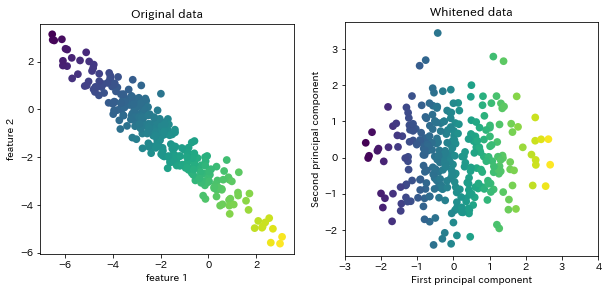

In [38]:
mglearn.plots.plot_pca_whitening()

In [39]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [40]:
print('X_train_pca shape: {}'.format(X_train_pca.shape))

X_train_pca shape: (1547, 100)


In [43]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [45]:
print('Test set accuracy: {:.2f}'.format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31


精度が23%から31%に上昇した。このことは主成分がデータのより良い表現となっているのではないかという直感を裏付けている。

In [46]:
print(pca.components_.shape)

(100, 5655)


画像は87*65のグレースケールだったので、主成分をこの形にもどして画像を表示してみよう

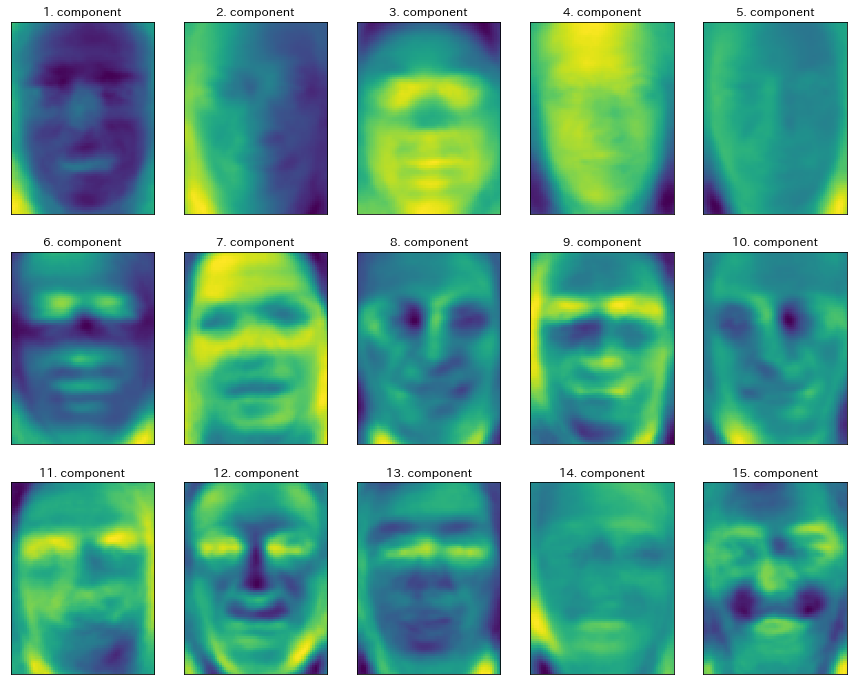

In [48]:
fig, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title('{}. component'.format(i+1))

この顔画像がどの側面を捉えているか解釈するのは難しい。  
例えば最初の主成分は顔と背景のコントラストをコーディングしていて、2つ目の主成分は光の当たり方による顔の左右の明るさをコーディングしているようにみえる。しかし人が顔を認識するときはこのような解釈はしないはずだ。主成分分析によってピクセルの表現はいくらか意味をもつが、それでもアルゴリズムと人の顔認識とは違うことを覚えておこう

PCAをこれまで、回転させてから分散が小さい成分を落とすものだと紹介してきた。PCAのもう一つの有用な解釈は、データポイントを主成分の重み付き和として表現する、一連の数字(PCAで回転後の新しい特徴量)を見つける手法だ、という解釈である。  



In [54]:
#dont work!!
#mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)